In [12]:
import sys
# from re import split
sys.path.append('../../../')
import os
# import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from impedance.circuits import CustomCircuit
from impedance.plotting import plot_nyquist
from impedance import preprocessing

import ImpedanceCorrection as IC
%reload_ext autoreload
%autoreload 2

In [13]:
direc = r'\Data'
print(os.getcwd())
all_files=glob.glob(os.getcwd() + direc + '\*.par')
all_files.sort()

f_name=all_files[1]
print(f_name)
freqs, Z= preprocessing.readVersaStudio(f_name)

C:\Users\shadd\OneDrive\Documents\Python\EIS
C:\Users\shadd\OneDrive\Documents\Python\EIS\Data\LSC_DPB1_FRXAS_700C_1%_EIS_OCV_before2.par


First, a simulated example with a somewhat representative circuit

Simulating circuit based on initial parameters
Simulating circuit based on initial parameters
Yes array
Capacitance that minimizes LY is:  0.0003582246075336796


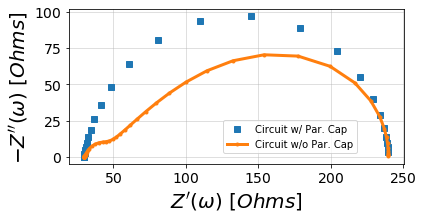

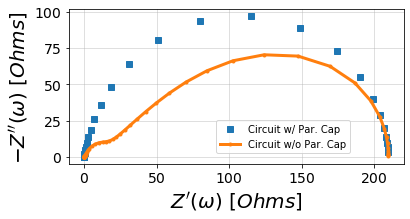

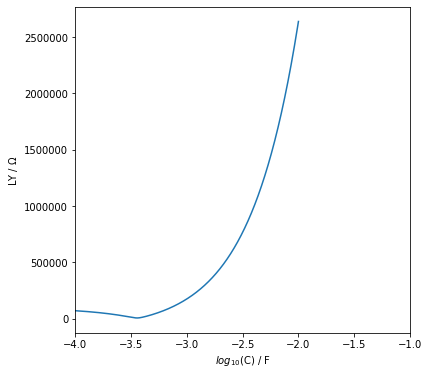

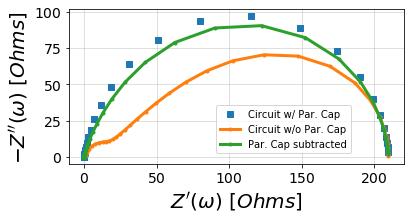

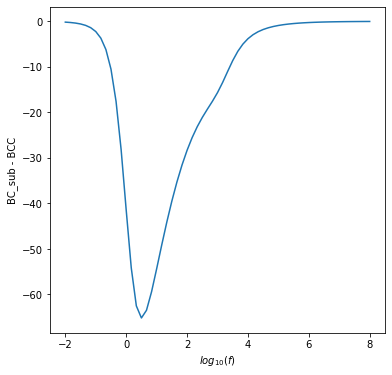

In [311]:
R_elyte = 30

circ = 'R1-p(E1,p(R2,C2)-G1)'
circCorr = 'R1-p(R2,C2)-G1)'

vals = [R_elyte, 8.233e-4, .96, 10, 1e-5, 200, .1]
valsCorr = [R_elyte, 10, 1e-5, 200, .1]


pred_freq = np.logspace(np.log10(1e8), np.log10(1e-2), num = freqs.size)

BertCirc = CustomCircuit(circ, initial_guess = vals)
BC_pred = BertCirc.predict(pred_freq)

BertCircCorr = CustomCircuit(circCorr, initial_guess = valsCorr)
BCC_pred = BertCircCorr.predict(pred_freq)

C_guess=np.logspace(-5,-2, num = 10000)

fig = plt.figure(figsize=(6,6))
ax0 = fig.add_subplot(111)
plot_nyquist(ax0, pred_freq, BC_pred,fmt='s')
plot_nyquist(ax0, pred_freq, BCC_pred)
fig.legend(labels=('Circuit w/ Par. Cap', 'Circuit w/o Par. Cap'), loc=(0.525,0.3))
# fig.savefig('Figures\Initial_BerthierCircuit.png', dpi=300, bbox_inches='tight')

fig = plt.figure(figsize=(6,6))
ax0 = fig.add_subplot(111)
plot_nyquist(ax0, pred_freq, BC_pred-R_elyte,fmt='s')
plot_nyquist(ax0, pred_freq, BCC_pred-R_elyte)
fig.legend(labels=('Circuit w/ Par. Cap', 'Circuit w/o Par. Cap'), loc=(0.525,0.3))
# fig.savefig('Figures\OhmicCorrected_BerthierCircuit.png', dpi=300, bbox_inches='tight')


BC_LY = IC.calcLY(C_guess, pred_freq, BC_pred-R_elyte)

fig = plt.figure(figsize=(6,6))
ax0 = fig.add_subplot(111)
plt.plot(np.log10(C_guess), BC_LY)
# ax0.set_ylim((0,10))
ax0.set_xlim((-4.001,-1))
ax0.set_ylabel('LY / $\Omega$')
ax0.set_xlabel('$log_{10}$(C) / F')
# fig.savefig('Figures\Correction_Function.png', dpi=300, bbox_inches='tight')

C_sub = C_guess[np.argmin(BC_LY)]
print('Capacitance that minimizes LY is: ', C_sub)

BC_sub = IC.par_cap_subtract(C_sub, pred_freq, BC_pred-R_elyte)

fig = plt.figure(figsize=(6,6))
ax0 = fig.add_subplot(111)
plot_nyquist(ax0, pred_freq, BC_pred-R_elyte,fmt='s')
plot_nyquist(ax0, pred_freq, BCC_pred-R_elyte)
plot_nyquist(ax0, pred_freq, BC_sub)
fig.legend(labels=('Circuit w/ Par. Cap', 'Circuit w/o Par. Cap', 'Par. Cap subtracted'), loc=(0.525,.3))
# fig.savefig('Figures\Corrected_BerthierCircuit.png', dpi=300, bbox_inches='tight')

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
plt.plot(np.log10(pred_freq), np.abs(BC_sub)-np.abs(BCC_pred-R_elyte))
ax1.set_ylabel('BC_sub - BCC')
ax1.set_xlabel('$log_{10}(f)$')
# fig.savefig('Figures\Correction_Error.png', dpi=300, bbox_inches='tight')
plt.show()

Now, trying to use some real data from the July 2018 trip

Yes array
Capacitance that minimizes LY is:  1.4352107926607617e-06


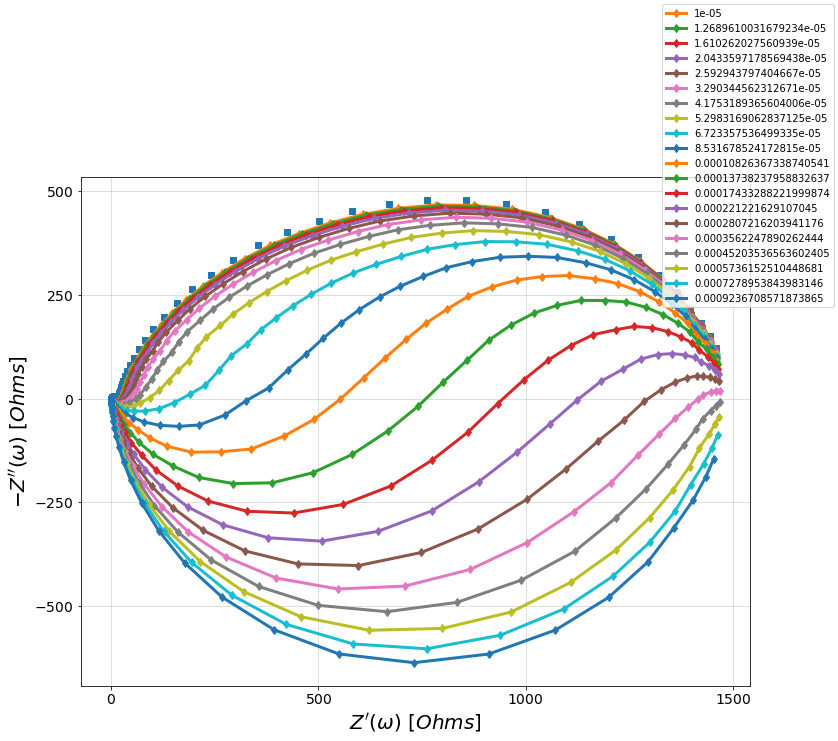

In [16]:
f0, Z0 = preprocessing.readVersaStudio(all_files[1])

f, Z = preprocessing.ignoreBelowX(f0, Z0)

Z = Z - Z[0]

#Just plotting data
# fig=plt.figure(figsize = (6, 6))
# ax0=fig.add_subplot(111)
# plot_nyquist(ax0, f, Z, fmt='s')
# fig.savefig('Figures\Initial_RealData.png', dpi=300, bbox_inches = 'tight')

#Calculating and plotting LY
C_guess =np.logspace(-7,-4, num = 10000)
LY1=IC.calcLY(C_guess, f[1:], Z[1:])

# fig = plt.figure(figsize = (6,6))
# ax0 = fig.add_subplot(111)
# plt.plot(np.log10(C_guess), LY1)
# # ax0.set_ylim((0, 10))
# # ax0.set_xlim((-4.001,-3))
# ax0.set_ylabel('LY / $\Omega$')
# ax0.set_xlabel('$log_{10}$(C) / F')
# fig.savefig('Figures\Correction_Fucntion_RealData.png', dpi=300, bbox_inches = 'tight')

C_sub = C_guess[np.argmin(LY1)]
print('Capacitance that minimizes LY is: ', C_sub)

Z_corr = []
C_subs = np.logspace(-5,-2, num = 30)

for i in range(20):
    Z_corr.append(IC.par_cap_subtract(C_subs[i], f[1:], Z[1:]))


# Z_corr = IC.par_cap_subtract(C_sub, f[1:], Z[1:])
fig=plt.figure(figsize = (12, 12))
ax0=fig.add_subplot(111)
plot_nyquist(ax0, f, Z, fmt = 's')
for i in range(20):
    
    plot_nyquist(ax0, f, Z_corr[i], fmt = '-d', label=str(C_subs[i]))
    
fig.legend()
# fig.legend(labels = ('Initial Impedance', 'Corrected Impedance'), loc = 'center')
# fig.savefig('Figures\CorrectedZ_RealData.png', dpi=300, bbox_inches = 'tight')
plt.show()

Doesn't work very well... Maybe we need to adjust the elements being removed with Berthier subtraction to include a resistor, too.

In [306]:
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import brute
from scipy import optimize

 active_mask: array([0.])
        cost: 20966506.730206694
         fun: array([6475.57051235])
        grad: array([5.5779852e+08])
         jac: array([[86138.89990234]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 35
        njev: 26
  optimality: 557798520.1738626
      status: 3
     success: True
           x: array([0.00035815])
 active_mask: array([0., 0.])
        cost: 34.29125456924544
         fun: array([8.28145574])
        grad: array([22954328.35542864,  -121604.35232626])
         jac: array([[2771774.5625844 ,  -14683.93434381]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 26
        njev: 8
  optimality: 22954328.355428644
      status: 3
     success: True
           x: array([8.23405564e-04, 9.59997771e-01])


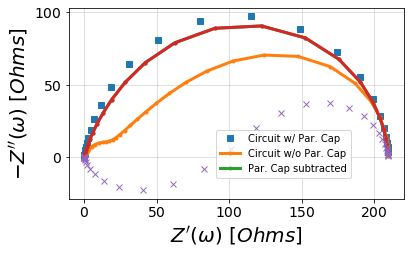

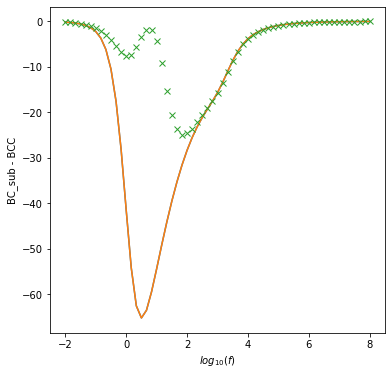

In [307]:
C0 = 1e-8
CPE0 = np.array([1e-8,.96])

resC = least_squares(IC.Par_Cap_Res, C0, method= 'trf', args=(pred_freq, BC_pred-R_elyte), max_nfev=2000)
print(resC)

resCPE = least_squares(IC.Par_CPE_Res, CPE0, method= 'trf', args=(pred_freq, BC_pred-R_elyte), max_nfev=2000)
print(resCPE)

BC_sub2 = IC.par_cap_subtract(resC.x[0], pred_freq, BC_pred-R_elyte)
BC_sub3 = IC.par_cap_subtract(resCPE.x[0], pred_freq, BC_pred-R_elyte)

fig, ax0 = plt.subplots(figsize=(6,6))
plot_nyquist(ax0, pred_freq, BC_pred-R_elyte,fmt='s')
plot_nyquist(ax0, pred_freq, BCC_pred-R_elyte)
plot_nyquist(ax0, pred_freq, BC_sub)
plot_nyquist(ax0, pred_freq, BC_sub2)
plot_nyquist(ax0, pred_freq, BC_sub3,fmt='x')
fig.legend(labels=('Circuit w/ Par. Cap', 'Circuit w/o Par. Cap', 'Par. Cap subtracted'), loc=(0.525,.3))
# fig.savefig('Figures\Corrected_BerthierCircuit.png', dpi=300, bbox_inches='tight')

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
plt.plot(np.log10(pred_freq), np.abs(BC_sub)-np.abs(BCC_pred-R_elyte))
plt.plot(np.log10(pred_freq), np.abs(BC_sub2)-np.abs(BCC_pred-R_elyte))
plt.plot(np.log10(pred_freq), np.abs(BC_sub3)-np.abs(BCC_pred-R_elyte),'x')
ax1.set_ylabel('BC_sub - BCC')
ax1.set_xlabel('$log_{10}(f)$')
# fig.savefig('Figures\Correction_Error.png', dpi=300, bbox_inches='tight')
plt.show()

 active_mask: array([0.])
        cost: 0.0067752116381803165
         fun: array([0.11640629])
        grad: array([15.6120979])
         jac: array([[134.11731034]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 23
        njev: 6
  optimality: 15.612097902121194
      status: 3
     success: True
           x: array([1.4296875e-06])
 active_mask: array([0., 0.])
        cost: 0.0057731113982071635
         fun: array([0.10745335])
        grad: array([3.8031034 , 0.00955285])
         jac: array([[35.39306443,  0.08890229]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 25
        njev: 9
  optimality: 3.8031034006345226
      status: 3
     success: True
           x: array([4.26962897e-06, 9.19999907e-01])


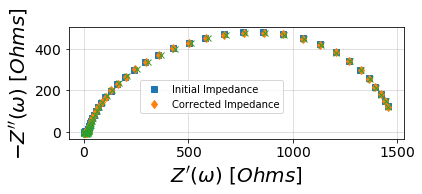

In [102]:
C0=1e-6
CPE0=np.array([1e-4,.92])

resC = least_squares(IC.Par_Cap_Res, C0, method= 'trf', args=(f[1:], Z[1:]), max_nfev=2000)
print(resC)

resCPE = least_squares(IC.Par_CPE_Res, CPE0, method= 'trf', args=(f[1:], Z[1:]), max_nfev=2000)
print(resCPE)

Z_corrC = IC.par_cap_subtract(resC.x[0], f[1:], Z[1:])
Z_corrCPE = IC.par_cap_subtract(resCPE.x[0], f[1:], Z[1:])

fig=plt.figure(figsize = (6, 6))
ax0=fig.add_subplot(111)
plot_nyquist(ax0, f, Z, fmt = 's')
plot_nyquist(ax0, f, Z_corrC, fmt = 'd')
plot_nyquist(ax0, f, Z_corrCPE, fmt = 'x')
fig.legend(labels = ('Initial Impedance', 'Corrected Impedance'), loc = 'center')
# fig.savefig('Figures\CorrectedZ_RealData.png', dpi=300, bbox_inches = 'tight')
plt.show()

In [287]:
CPE0 = np.array([7.94328e-4, .97])
rrange = ((6.3095e-4, 1e-3), (.95, .97))

d_st = 3e-16
x_t = xtol=3e-16
f_t = ftol=3e-16
g_t = gtol=3e-16

In [309]:
resCPEin = least_squares(IC.Par_CPE_Res, CPE0, method= 'trf', loss='soft_l1', args=(pred_freq, BC_pred-R_elyte), max_nfev=2000, diff_step=d_st, xtol=x_t, ftol=f_t, gtol=g_t)

bruteout20 = brute(IC.Par_CPE_Res, rrange, Ns=20, args=(pred_freq, BC_pred-R_elyte), full_output=True, finish=optimize.fmin, workers=-1)
bruteout100 = brute(IC.Par_CPE_Res, rrange, Ns=100, args=(pred_freq, BC_pred-R_elyte), full_output=True, finish=optimize.fmin, workers=-1)

resCPEout = least_squares(IC.Par_CPE_Res, bruteout100[0], method= 'trf', loss='soft_l1', args=(pred_freq, BC_pred-R_elyte), max_nfev=2000, diff_step=d_st, xtol=x_t, ftol=f_t, gtol=g_t)

LS_only = IC.par_CPE_subtract(resCPEin.x, pred_freq, BC_pred-R_elyte)
Bru100_only = IC.par_CPE_subtract(bruteout100[0], pred_freq, BC_pred-R_elyte)
LS_Bru100 = IC.par_CPE_subtract(resCPEout.x, pred_freq, BC_pred-R_elyte)

print(resCPEin, bruteout100[0], resCPEout)

 active_mask: array([0., 0.])
        cost: 50.54008975185502
         fun: array([51.53038765])
        grad: array([  0.        , 682.53815894])
         jac: array([[0.        , 1.84497694]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 119
        njev: 87
  optimality: 682.5381589404196
      status: 3
     success: True
           x: array([6.16221151e-04, 9.60002082e-01]) [3.26728417e-04 9.99403518e-01]  active_mask: array([0., 0.])
        cost: 0.035905033677682274
         fun: array([0.27036871])
        grad: array([-10.33501376, 204.05660954])
         jac: array([[-37.55732567, 741.53946188]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 34
        njev: 9
  optimality: 204.05660953794617
      status: 3
     success: True
           x: array([3.26730188e-04, 9.99403519e-01])


In [290]:
bruteout1000 = brute(IC.Par_CPE_Res, rrange, Ns=1000, args=(pred_freq, BC_pred-R_elyte), full_output=True, finish=optimize.fmin, workers=-1)

In [291]:
Bru1000_only = IC.par_CPE_subtract(bruteout1000[0], pred_freq, BC_pred-R_elyte)

In [292]:
resCPEout2 = least_squares(IC.Par_CPE_Res, bruteout1000[0], method= 'trf', loss='soft_l1', args=(pred_freq, BC_pred-R_elyte), max_nfev=2000, diff_step=d_st, xtol=x_t, ftol=f_t, gtol=g_t)
LS_Bru1000 = IC.par_CPE_subtract(resCPEout2.x, pred_freq, BC_pred-R_elyte)
print(resCPEout2)

 active_mask: array([0., 0.])
        cost: 1.8608034777624813
         fun: array([2.68033515])
        grad: array([ 5759.88479784, 39056.94291587])
         jac: array([[1270.5175906 , 8615.19539908]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 31
        njev: 6
  optimality: 39056.942915868734
      status: 3
     success: True
           x: array([8.24233957e-04, 9.59949693e-01])


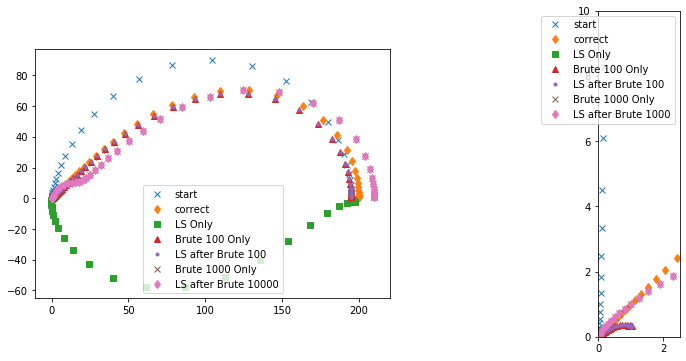

In [310]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,6))
Yel1 = 1/(BC_pred-R_elyte)
Yel2 = 1/(BCC_pred-R_elyte)
Yel3 = 1/LS_only
Yel4 = 1/Bru100_only
Yel5 = 1/LS_Bru100
Yel6 = 1/Bru1000_only
Yel7 = 1/LS_Bru1000

ax1.plot(np.real(BC_pred-R_elyte), -np.imag(BC_pred-R_elyte), 'x', label='start')
ax1.plot(np.real(BCC_pred-R_elyte), -np.imag(BCC_pred-R_elyte), 'd', label='correct')
ax1.plot(np.real(LS_only), -np.imag(LS_only), 's', label='LS Only')
ax1.plot(np.real(Bru100_only), -np.imag(Bru100_only), '^', label='Brute 100 Only')
ax1.plot(np.real(LS_Bru100), -np.imag(LS_Bru100), '.', label='LS after Brute 100')
ax1.plot(np.real(Bru1000_only), -np.imag(Bru1000_only), 'x', label='Brute 1000 Only')
ax1.plot(np.real(LS_Bru1000), -np.imag(LS_Bru1000), 'd', label='LS after Brute 10000')

# ax1.set_ylim(0,4)
# ax1.set_xlim(0,4)
ax1.set_aspect('equal')
ax1.legend()


ax2.plot(np.real(Yel1), np.imag(Yel1), 'x', label='start')
ax2.plot(np.real(Yel2), np.imag(Yel2), 'd', label='correct')
ax2.plot(np.real(Yel3), np.imag(Yel3), 's', label='LS Only')
ax2.plot(np.real(Yel4), np.imag(Yel4), '^', label='Brute 100 Only')
ax2.plot(np.real(Yel5), np.imag(Yel5), '.', label='LS after Brute 100')
ax2.plot(np.real(Yel6), np.imag(Yel6), 'x', label='Brute 1000 Only')
ax2.plot(np.real(Yel7), np.imag(Yel7), 'd', label='LS after Brute 1000')

ax2.set_xlim(-.01,2.5)
ax2.set_ylim(0,10)
ax2.set_aspect('equal')
ax2.legend()


plt.show()

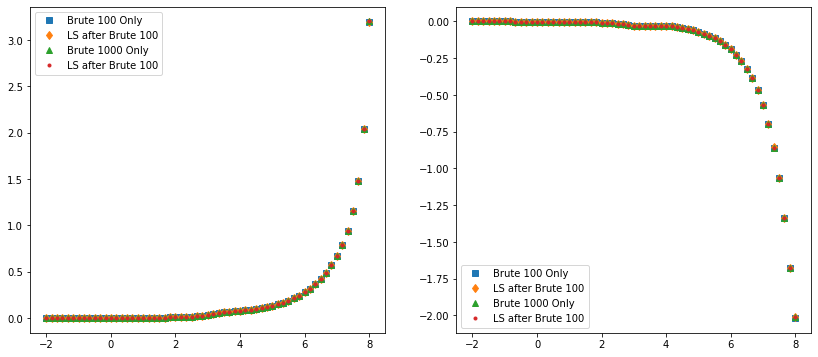

In [299]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14 ,6))

Z_corr = BCC_pred - R_elyte

# ax1.plot(np.log10(pred_freq), np.real((LS_only-Z_corr)/Z_corr), 'x', label='LS Only')
ax1.plot(np.log10(pred_freq), np.real((Bru100_only-Z_corr)/Z_corr), 's', label='Brute 100 Only')
ax1.plot(np.log10(pred_freq), np.real((LS_Bru100-Z_corr)/Z_corr), 'd', label='LS after Brute 100')
ax1.plot(np.log10(pred_freq), np.real((Bru1000_only-Z_corr)/Z_corr), '^', label='Brute 1000 Only')
ax1.plot(np.log10(pred_freq), np.real((LS_Bru1000-Z_corr)/Z_corr), '.', label='LS after Brute 100')
ax1.legend()

# ax2.plot(np.log10(pred_freq), -np.imag((LS_only-Z_corr)/Z_corr), 'x', label='LS Only')
ax2.plot(np.log10(pred_freq), -np.imag((Bru100_only-Z_corr)/Z_corr), 's', label='Brute 100 Only')
ax2.plot(np.log10(pred_freq), -np.imag((LS_Bru100-Z_corr)/Z_corr), 'd', label='LS after Brute 100')
ax2.plot(np.log10(pred_freq), -np.imag((Bru1000_only-Z_corr)/Z_corr), '^', label='Brute 1000 Only')
ax2.plot(np.log10(pred_freq), -np.imag((LS_Bru1000-Z_corr)/Z_corr), '.', label='LS after Brute 100')
ax2.legend()

plt.show()